In [1]:
import config
import os
import random
import utils

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# For LSTM
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

%matplotlib inline

In [2]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [6]:
def format_scale_data(data, weeks=1):
    X_total = data.values[:209, :]

    data = X_total[(53-weeks):, :]
    print(data.shape)
    scaler, values = utils.scale(data)
    values = utils.series_to_supervised(values, n_in=weeks, n_out=1, dropnan=True).values

    y_scaler, y = utils.scale(data[:, 1].reshape((len(data), 1)))

    train = values[:140, :]
    valid1 = values[140:144, :]
    valid2 = values[144:148, :]
    test = values[148:, :]
    

    features = 13
    obs = weeks*features

    y = values[:, -features:]

    trainX = train[:, :obs]
    trainY = train[:, -features:][:, 1]
    validX1 = valid1[:, :obs]
    validY1 = valid1[:, -features:][:, 1]
    validX2 = valid2[:, :obs]
    validY2 = valid2[:, -features:][:, 1]
    testX = test[:, :obs]
    testY = test[:, -features:][:, 1]

    trainX = trainX.reshape((trainX.shape[0], weeks, features))
    validX1 = validX1.reshape((validX1.shape[0], weeks, features))
    validX2 = validX2.reshape((validX2.shape[0], weeks, features))
    testX = testX.reshape((testX.shape[0], weeks, features))
    
    print(trainX.shape, validX1.shape, validX2.shape, testX.shape)

    return trainX, trainY, validX1, validY1, validX2, validY2, testX, testY, scaler, y_scaler

In [3]:
def format_scale_data_2(data, weeks=1):
    X_total = data.values[:209, :]

    data = X_total[(109-weeks):, :]
    print(data.shape)
    scaler, values = utils.scale(data)
    values = utils.series_to_supervised(values, n_in=weeks, n_out=1, dropnan=True).values

    y_scaler, y = utils.scale(data[:, 1].reshape((len(data), 1)))

    train = values[:84, :]
    valid1 = values[84:88, :]
    valid2 = values[88:92, :]
    test = values[92:, :]
    

    features = 13
    obs = weeks*features

    y = values[:, -features:]

    trainX = train[:, :obs]
    trainY = train[:, -features:][:, 1]
    validX1 = valid1[:, :obs]
    validY1 = valid1[:, -features:][:, 1]
    validX2 = valid2[:, :obs]
    validY2 = valid2[:, -features:][:, 1]
    testX = test[:, :obs]
    testY = test[:, -features:][:, 1]

    trainX = trainX.reshape((trainX.shape[0], weeks, features))
    validX1 = validX1.reshape((validX1.shape[0], weeks, features))
    validX2 = validX2.reshape((validX2.shape[0], weeks, features))
    testX = testX.reshape((testX.shape[0], weeks, features))
    
    print(trainX.shape, validX1.shape, validX2.shape, testX.shape)

    return trainX, trainY, validX1, validY1, validX2, validY2, testX, testY, scaler, y_scaler

In [10]:
def load_eval_model(name, w, output, second=False):
    lstm = load_model('Model/{}'.format(name))
    print(lstm.summary())
    
    saltlake_week = pd.read_csv('../saltlake_week.csv')
    data = saltlake_week[['Cases', 'VMT (Veh-Miles)', 'News Sentiment', 'Unemployment Rate', 'PRCP', 'SNWD',
                          'Percent_Fully_Vaccinated_5&Older', 'TAVG', 
                          'Stay at Home', 'Mask', 'School Opening', 'Health Emergency', 'Holiday']]
    
    if second:
        trainX, trainY, validX1, validY1, validX2, validY2, testX, testY, scaler, y_scaler = format_scale_data_2(data=data, 
                                                                                                            weeks=w)
    else:
        trainX, trainY, validX1, validY1, validX2, validY2, testX, testY, scaler, y_scaler = format_scale_data(data=data, 
                                                                                                            weeks=w)
    
    print(lstm.evaluate(validX2, validY2))
    
    lstm.save('Model/LSTM-2-4')
    
    yhat_valid2 = lstm.predict(validX2)
    yhat_valid2_inv = y_scaler.inverse_transform(yhat_valid2)
    validY2_inv = y_scaler.inverse_transform(validY2.reshape((-1, 1)))
    
    yhat_train = lstm.predict(trainX)
    yhat_train_inv = y_scaler.inverse_transform(yhat_train)
    trainY_inv = y_scaler.inverse_transform(trainY.reshape((-1, 1)))
    
    print("Mean Squared Error: {}".format(mean_squared_error(validY2_inv, yhat_valid2_inv)))
    print("Root Mean Squared Error: {}".format(mean_squared_error(validY2_inv, yhat_valid2_inv, squared=False)))
    print("Mean Absolute Percentage Error: {}".format(mean_absolute_percentage_error(validY2_inv, yhat_valid2_inv)))
    
    plt.figure()
    plt.plot(yhat_valid2_inv, label='Predicted')
    plt.plot(validY2_inv, label='True')
    plt.legend()
    plt.title("Validation Data 2")
    plt.show()
    
    plt.figure()
    plt.plot(yhat_train_inv, label='Predicted')
    plt.plot(trainY_inv, label='True')
    plt.legend()
    plt.title("Training Data")
    plt.show()
    
    utils.plot_predicted(validY2_inv, yhat_valid2_inv, "{} Validation Data 2".format(name), output)

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_242 (LSTM)             (None, 2, 116)            60320     
                                                                 
 dropout_242 (Dropout)       (None, 2, 116)            0         
                                                                 
 lstm_243 (LSTM)             (None, 2, 84)             67536     
                                                                 
 dropout_243 (Dropout)       (None, 2, 84)             0         
                                                                 
 lstm_244 (LSTM)             (None, 2, 48)             25536     
                                                                 
 dropout_244 (Dropout)       (None, 2, 48)             0         
                                                                 
 lstm_245 (LSTM)             (None, 16)              

INFO:tensorflow:Assets written to: Model/LSTM-2-4\assets


Mean Squared Error: 9153270284870.598
Root Mean Squared Error: 3025437.205573865
Mean Absolute Percentage Error: 0.03482802826822405


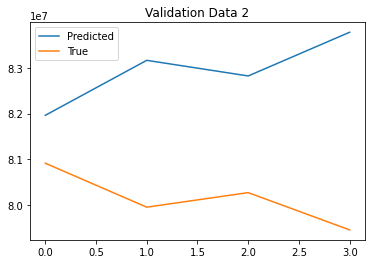

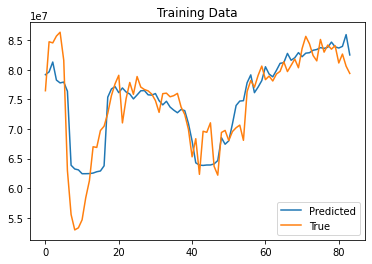

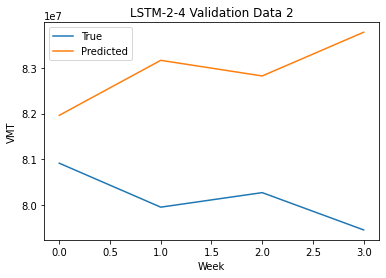

In [12]:
load_eval_model('LSTM-2-4', 2, 'output/lstm2-4_val2.jpg', second=True)